In [1]:
from __future__ import annotations
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from typing import Literal

#### Import all datasets of All Pulau Kumala's Infrastructures
All datasets will be concated into one single dataframe. It'll be necessary to have same dimension of columns to avoid further data error in processing. All datasets that used with variant total of rows is:
- `dataset_arena_balap_gokart.csv`: 1 rows.
- `dataset_candi_naga_lembuswana.csv`: 1 rows.
- `dataset_dayak_experience_center.csv`: 25 rows.
- `dataset_jembatan_penyebrangan_pulau_kumala.csv`: 1 rows.
- `dataset_kumala_central_park.csv`: 1 rows.
- `dataset_kumala_island.csv`: 1 rows.
- `dataset_patung_lembuswana_area_sps.csv`: 1 rows.
- `dataset_pulau_kumala.csv`: 1 rows.
- `dataaset_sky_tower_kumala.csv`: 1 rows.
- `dataset_taman_air_mancur_pulau_kumala.csv`: 1 rows.
- `dataset_wisata_tenggarong_kolam_naga.csv`: 1 rows.

In [2]:
# import all the necessary modules
import os
import re
import torch
import emoji
from glob import glob
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

d:\suarasiy\skripsi\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define function for pre-processing

# return None if the review is "[no_review]"
def remove_empty_review (review: str) -> str:
    return None if review == "[no_review]" else review

# remove urls from the text contain urls
def remove_urls (text: str):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# convert emoji to meaningful text
def convert_emojis (text: str):
    return emoji.demojize(text)

In [4]:
# initialize path to datasets
path_to_datasets = "{}\\datasets".format(os.getcwd())
all_datasets = (pd.read_csv(f) for f in glob(os.path.join(path_to_datasets, "*.csv")))

# concatenate all the datasets
data = pd.concat(all_datasets, ignore_index=True)

# select only columns "review"
data = data[["review"]]

In [5]:
# pre-processing the data

# remove empty reviews by value "[no_review]", then drop the rows with NaN values
data['review'] = data['review'].apply(remove_empty_review)
data = data.dropna(subset=['review'])

# remove urls
data['review'] = data['review'].apply(remove_urls)

# convert emojis
data['review'] = data['review'].apply(convert_emojis)

In [6]:
# tokenize with nlptown/bert-base-multilingual-uncased-sentiment tokenizer and model
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Define function to tokenize the reviews
def predict_sentiment(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    return predicted_label

# giving labels to the reviews
data['sentiment'] = data['review'].apply(predict_sentiment)

In [7]:
# Define function to tokenize the reviews
def extract_features(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states

    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = hidden_states[-1][:, 0, :].squeeze().numpy()

    return cls_embedding

# extract features from the reviews
data['features'] = data['review'].apply(extract_features)

In [8]:
data

,review,sentiment,features
0,"OK, I have it",2,"[0.021978065, 0.07565795, -0.057591636, -0.515..."
1,The place is good for taking photos,3,"[-0.2428127, -0.61732364, -0.2426435, 0.095686..."
2,A unique and interesting island located in the...,3,"[0.4399781, -0.5964806, -0.17686953, 0.4701182..."
3,One of the tourist destinations on Kumala Isla...,3,"[0.16553363, -0.21731222, -0.16979444, 0.08522..."
4,"Amazing... As a Dayak person, I am very proud ...",4,"[0.5537336, -0.4003766, -0.14024235, -0.071828..."
...,...,...,...
574,Exciting,4,"[-0.04097183, -0.42315218, -0.106969014, -0.15..."
575,Reasonable,2,"[-0.5042372, -0.09283149, -0.06390904, -0.4116..."
576,Great,4,"[0.037463196, -0.4012439, -0.11197753, -0.1062..."
577,"Tenggarong, East Kalimantan",3,"[0.007266119, -0.15634911, -0.08427003, -0.076..."


Accuracy: 0.8585858585858586
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.86      0.92         7
           2       0.73      0.84      0.78        19
           3       0.85      0.85      0.85        40
           4       0.96      0.85      0.90        27

    accuracy                           0.86        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.87      0.86      0.86        99



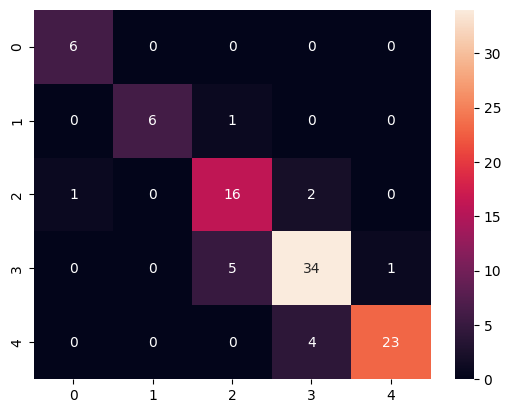

In [9]:
# perform chi-square feature selection
X = np.stack(data['features'])
y = data['sentiment']

# scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# select the best features
# selector = SelectKBest(chi2, k=500)
# X_selected = selector.fit_transform(X_scaled, y)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# save the model
# torch.save(model, 'model.pt')

# save the tokenizer
# tokenizer.save_pretrained('tokenizer')

# save the scaler
# torch.save(scaler, 'scaler.pt')

# save the selector
# torch.save(selector, 'selector.pt')

# save the data
# data.to_csv('data.csv', index=False)

In [10]:
# Define the target variable
target = data['sentiment']

# Convert the BERT features to a list of arrays
features = np.array(data['features'].tolist())

# Apply Min-Max scaling to ensure all values are non-negative
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

k_values = [100, 200, 300, 400, 500]

best_k = 0
best_score = 0

# Split the data into training and testing sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

for k in k_values:
    chi2_selector = SelectKBest(chi2, k=k)
    X_train_kbest = chi2_selector.fit_transform(X_train, y_train)

    clf = GaussianNB()

    scores = cross_val_score(clf, X_train_kbest, y_train, cv=5)
    mean_score = scores.mean()

    print (f'k={k}, mean accuracy={mean_score}')

    if mean_score > best_score: best_k = k; best_score = mean_score

print(f'Best k={best_k}, best score={best_score}')

# Apply chi-square feature selection to select the top best_k features
chi2_selector = SelectKBest(chi2, k=best_k)
X_train_kbest = chi2_selector.fit_transform(X_train, y_train)
X_test_kbest = chi2_selector.transform(X_test)

k=100, mean accuracy=0.7362318840579709
k=200, mean accuracy=0.7884057971014493
k=300, mean accuracy=0.8173913043478261
k=400, mean accuracy=0.8231884057971014
k=500, mean accuracy=0.8550724637681159
Best k=500, best score=0.8550724637681159


In [11]:
# # Define the target variable
# target = data['sentiment']

# # Convert the BERT features to a list of arrays
# features = np.array(data['features'].tolist())

# # Apply Min-Max scaling to ensure all values are non-negative
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features)

# # Split the data into training and testing sets with a 70:30 ratio
# X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# Train a Naive Bayes classifier on the selected features
clf = GaussianNB()
clf.fit(X_train_kbest, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test_kbest)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.8851351351351351
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.92      1.00      0.96        11
           2       0.79      0.97      0.87        31
           3       0.93      0.83      0.88        60
           4       0.90      0.90      0.90        39

    accuracy                           0.89       148
   macro avg       0.91      0.88      0.89       148
weighted avg       0.89      0.89      0.88       148



In [ ]:
# Apply Min-Max scaling to ensure all values are non-negative
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features)

# Train a Naive Bayes classifier
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

# Predict the test set
# y_pred = nb.predict(X_test)

# Evaluate the classifier's performance
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print('Classification Report:\n', report)

In [ ]:
# Apply chi-square feature selection
k_best = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
X_train_k_best = k_best.fit_transform(X_train, y_train)
X_test_k_best = k_best.transform(X_test)

# Train a Naive Bayes classifier with the selected features
nb_k_best = MultinomialNB()
nb_k_best.fit(X_train_k_best, y_train)

# Predict the test set with the selected features
y_pred_k_best = nb_k_best.predict(X_test_k_best)

# Evaluate the classifier's performance with the selected features
accuracy_k_best = accuracy_score(y_test, y_pred_k_best)
report_k_best = classification_report(y_test, y_pred_k_best)

print(f'Accuracy with Chi-Square selected features: {accuracy_k_best}')
print('Classification Report with Chi-Square selected features:\n', report_k_best)